<h1><center> Use of geoprocessing to highlight the improvement of air quality in relation to confinement due to covid-19</center></h1>

In [ ]:
import arcpy
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

root = "D:/Arcgis/Airparif2/"
arcpy.env.workspace = root

### First we have to check if the date wanted by the user is contained in the database

#### Importing all dates from the database into a list

In [ ]:
all_dates_debut =[]
for row in arcpy.da.SearchCursor("mes_idf_horaire_no2.shp", "date_debut"):
    all_dates_debut.append(row)

all_dates = []
for date in all_dates_debut:
    all_dates.append(date[0])

#### Function for checking whether an entered date is in the database

In [ ]:
def test_date(d,m,y,h):
    
#   if statements to be compatible with the database format: '2020-04-01T08:00:00.000Z'

    if h < 10:
        h = "0" + str(h)
    
    if d < 10:
        d = "0" + str(d)
    
    if m < 10:
        m = "0" + str(m)

    date = str(y) + '-' + str(m) + '-' + str(d) + 'T' + h + ':00:00.000Z'
    
    return date in all_dates

### IDW function to calculate the interpolation of pollution at a user-defined date
#### Since we know the NO2 measurements at each station, it is possible to determine the pollution levels between stations using this interpolation function

In [ ]:
def IDW(d,m,y,h):

#   if statements to be compatible with the database format: '2020-04-01T08:00:00.000Z'
    
    if h < 10:
        h = "0" + str(h)
    
    if d < 10:
        d = "0" + str(d)
    
    if m < 10:
        m = "0" + str(m)

    date = "'" + str(y) + '-' + str(m) + '-' + str(d) + 'T' + h + ':00:00.000Z' + "'"
    
    if arcpy.Exists("selection_lyr"):
        arcpy.Delete_management("selection_lyr")
        
    arcpy.MakeFeatureLayer_management("mes_idf_horaire_no2.shp", "selection_lyr")
    
    layer_name = "Result_" +  str(m) + '_' + str(d) + '_' + str(y)+ '_'  + h + ".shp"
    
    if arcpy.Exists(layer_name):
        arcpy.Delete_management(layer_name)
    
    qry = "date_debut = " + date

#   SQL queries to select the results of the dates entered
    
    arcpy.SelectLayerByAttribute_management("selection_lyr", 'NEW_SELECTION', qry)
    arcpy.CopyFeatures_management("selection_lyr", layer_name)
    
    Idw_name = "Idw_" + str(m) + '_' + str(d) + '_' + str(y)+ '_'  + h + ".tif"
    
    if arcpy.Exists(root + Idw_name):
                arcpy.Delete_management(root + Idw_name)
            
    inPointFeatures = layer_name
    zField = "valeur"

#   Interpolations with IDW tool according to the pollution
    
    Idw = arcpy.sa.Idw(inPointFeatures, zField)
    
    return Idw

### Difference_IDW function to return the difference between IDW1 and IDW2

In [ ]:
def Difference_IDW(Idw1,Idw2):

#   Calculation of the raster showing pollution difference between the first date and the second date
    
    DifferenceRasterName = root + "Difference"
    
    if arcpy.Exists(DifferenceRasterName):
                arcpy.Delete_management(DifferenceRasterName)

    arcpy.CheckOutExtension("Spatial")
    
    DifferenceRaster = Idw1 - Idw2
    
    return DifferenceRaster

### SumPop function to return the number of inhabitants whose pollution has decreased by a certain user-defined threshold

In [ ]:
def SumPop(DifferenceRaster,delta):    

    BinaryName = "Binaire"
    
    if arcpy.Exists(root + BinaryName):
                arcpy.Delete_management(root + BinaryName)

#   Use of the Con function to get a binary raster showing where pollution is over (-> 1) or under (-> 0) the threshold
            
    Binaire = arcpy.sa.Con(DifferenceRaster, 1, 0, "VALUE > " + str(delta))
    
#   We retrieve the population density from another file

    population_density = arcpy.Raster(root + "FranceRasters.gdb/France_ppp_2020_1km")

    PopulationName = "Population"
    
    if arcpy.Exists(root + PopulationName):
                arcpy.Delete_management(root + PopulationName)
            
#   We multiply the binary raster with the population density to get a raster showing the density of population above
#   the threshold

    Population = Binaire * population_density
    Population.save(root + PopulationName)
    
#   We convert this raster to a numpy array to be able to sum all the population

    data = arcpy.RasterToNumPyArray(Population)
    somme = np.sum(data)
    return somme

### varDelta function to return the graph of the number of inhabitants as a function of the pollution reduction threshold for 2 user-defined dates

In [ ]:
def varDelta(d1,m1,y1,d2,m2,y2,h1,h2,deltaMax):

#   We check if the date exists, if so, we run the function

    if test_date(d1,m1,y1,h1) and test_date(d2,m2,y2,h2):
        
        sumPopulation = []
        delta = np.arange(deltaMax+1)
        Idw1 = IDW(d1,m1,y1,h1)
        Idw2 = IDW(d2,m2,y2,h2)
        Raster = Difference_IDW(Idw1,Idw2)
        
#       We calculated the raster difference, and the for statement is used to calculate the number of inhabitants for every
#       threshold from 0 to deltaMax
        
        for i in delta:
            
            sumPopulation.append(SumPop(Raster,i))
#             print(i, "\n", sumPopulation[i])

        sumPopulation = np.array(sumPopulation) / 1e6 # to plot in millions of inhabitants

        plt.plot(delta,sumPopulation)
        plt.title("Change in the number of inhabitants whose air quality has improved between " + str(d2) + '-' + str(m2) + '-' + str(y2) + " and " + str(d1) + '-' + str(m1) + '-' + str(y1))
        plt.xlabel("Decrease of pollution (µg/m$^3$)")
        plt.ylabel("Number of inhabitants (millions)")
        plt.grid()
    
#   If the date doesn't exit in the database, we print an error message showing which date isn't correct
    
    elif not(test_date(d1,m1,y1,h1)) and not(test_date(d2,m2,y2,h2)):
        print("Both dates are not in the database")
    elif not(test_date(d1,m1,y1,h1)):
        print("The first date is not in the database")
    else:
        print("The second date is not in the database")

### Use of the varDelta function

Results:
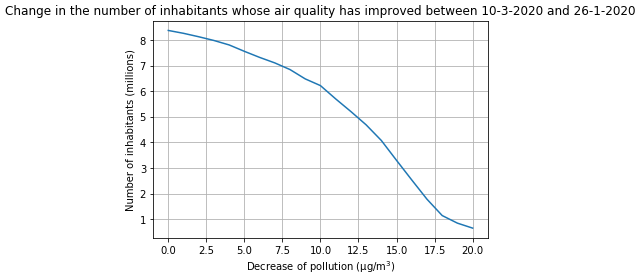

In [ ]:
day1 = input("Choose the day of the first date: ")
month1 = input("Choose the month of the first date: ")
year1 = input("Choose the year of the first date: ")
hour1 = input("Choose the hour of the first date: ")

day2 = input("Choose the day of the second date: ")
month2 = input("Choose the month of the second date: ")
year2 = input("Choose the year of the second date: ")
hour2 = input("Choose the hour of the second date: ")

threshold = input("Choose the maximum threshold of pollution: ")

varDelta(day1,month1,year1,day2,month2,year2,hour1,hour2,threshold)

### varDateMonth function to return the graph of the number of inhabitants whose pollution has decreased by more than a certain level each month between two user-defined dates

In [ ]:
def varDateMonth(d1,m1,y1,d2,m2,y2,h1,h2,delta):
    
#   We check if the date exists, if so, we run the function

    if test_date(d1,m1,y1,h1) and test_date(d2,m2,y2,h2):
        
        month = m1+1
        year = y1
        sumPopulation = [0]

        Idw1 = IDW(d1,m1,y1,h1)

#       We calculate the amount of people each month from the first date to the second date relatively to the first date

        while datetime(year,month,d1) < datetime(y2,m2,d2):

            Idw2 = IDW(d2,month,year,h2)
            Raster = Difference_IDW(Idw1,Idw2)
            sumPopulation.append(SumPop(Raster,delta))

#      We increment the date to do the calculation for the following month

            if month < 12:
                month += 1
            else:
                month = 1
                year += 1

#       We calculate the amount of people at the second date
                
        Idw2 = IDW(d2,m2,y2,h2)

        Raster = Difference_IDW(Idw1,Idw2)

        sumPopulation.append(SumPop(Raster,delta))

        sumPopulation = np.array(sumPopulation) / 1e6

        n_month = np.arange(len(sumPopulation))

        plt.plot(n_month,sumPopulation)

        plt.title("Number of inhabitants whose air quality has improved by " + str(delta) + " (µg/m$^3$) between " + str(d2) + '-' + str(m2) + '-' + str(y2) + " and " + str(d1) + '-' + str(m1) + '-' + str(y1))
        plt.xlabel("Nomber of month(s)")
        plt.ylabel("Number of inhabitants (millions)")
        
#   If the date doesn't exit in the database, we print an error message showing which date isn't correct
    
    elif not(test_date(d1,m1,y1,h1)) and not(test_date(d2,m2,y2,h2)):
        print("Both dates are not in the database")
    elif not(test_date(d1,m1,y1,h1)):
        print("The first date is not in the database")
    else:
        print("The second date is not in the database")

### Use of the varDateMonth function

Results:
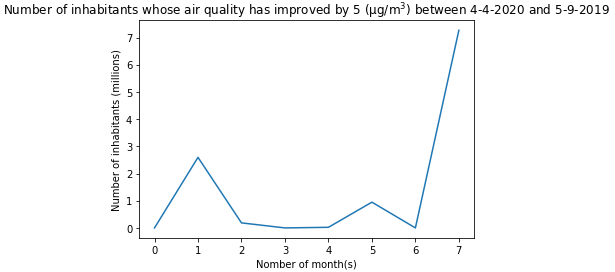

In [ ]:
day1 = input("Choose the day of the first date: ")
month1 = input("Choose the month of the first date: ")
year1 = input("Choose the year of the first date: ")
hour1 = input("Choose the hour of the first date: ")

day2 = input("Choose the day of the second date: ")
month2 = input("Choose the month of the second date: ")
year2 = input("Choose the year of the second date: ")
hour2 = input("Choose the hour of the second date: ")

threshold = input("Choose the threshold of pollution: ")

varDateMonth(day1,month1,year1,day2,month2,year2,hour1,hour2,threshold)

### varDateDay function to return the graph of the number of inhabitants whose pollution has decreased by more than a certain level each day between two user-defined dates

In [ ]:
def varDateDay(d1,m1,y1,d2,m2,y2,h1,h2,delta):
    
#   We check if the date exists, if so, we run the function

    if test_date(d1,m1,y1,h1) and test_date(d2,m2,y2,h2):
        
        month = m1
        year = y1
        day = d1+1
        sumPopulation = [0]

        monthsDays = [31,28,31,30,31,30,31,31,30,31,30,31]

        Idw1 = IDW(d1,m1,y1,h1)
        
#       We calculate the amount of people each day from the first date to the second date relatively to the first date

        while datetime(year,month,day) < datetime(y2,m2,d2):
            Idw2 = IDW(day,month,year,h2)
            Raster = Difference_IDW(Idw1,Idw2)
            sumPopulation.append(SumPop(Raster,delta))

            if (year%4 == 0 and year%100 != 0) or year%400 == 0:
                monthsDays[1] = 29
            else:
                monthsDays[1] = 28

            if day < monthsDays[month-1]:
                day +=1
            else:
                day = 1

                if month < 12:
                    month += 1
                else:
                    month = 1
                    year += 1

#       We calculate the amount of people at the second date
                    
        Idw2 = IDW(d2,m2,y2,h2)
        Raster = Difference_IDW(Idw1,Idw2)
        sumPopulation.append(SumPop(Raster,delta))

        sumPopulation = np.array(sumPopulation) / 1e6

        n_day = np.arange(len(sumPopulation))

        plt.plot(n_day,sumPopulation)
        
        plt.title("Number of inhabitants whose air quality has improved by " + str(delta) + " (µg/m$^3$) between " + str(d2) + '-' + str(m2) + '-' + str(y2) + " and " + str(d1) + '-' + str(m1) + '-' + str(y1))
        plt.xlabel("Number of day(s)")
        plt.ylabel("Number of inhabitants (millions)")
        
#   If the date doesn't exit in the database, we print an error message showing which date isn't correct
    
    elif not(test_date(d1,m1,y1,h1)) and not(test_date(d2,m2,y2,h2)):
        print("Both dates are not in the database")
    elif not(test_date(d1,m1,y1,h1)):
        print("The first date is not in the database")
    else:
        print("The second date is not in the database")

### Use of the varDateDay function

Results:
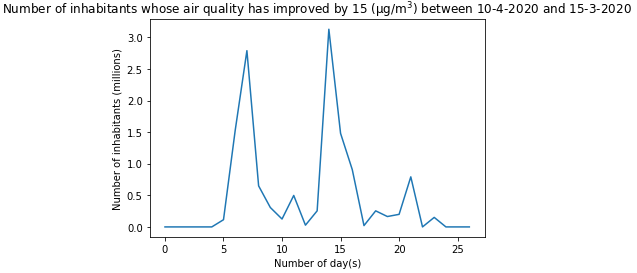

In [ ]:
day1 = input("Choose the day of the first date: ")
month1 = input("Choose the month of the first date: ")
year1 = input("Choose the year of the first date: ")
hour1 = input("Choose the hour of the first date: ")

day2 = input("Choose the day of the second date: ")
month2 = input("Choose the month of the second date: ")
year2 = input("Choose the year of the second date: ")
hour2 = input("Choose the hour of the second date: ")

threshold = input("Choose the threshold of pollution: ")

varDateDay(day1,month1,year1,day2,month2,year2,hour1,hour2,threshold)

### Pop_pollu function to return the number of inhabitants whom pollution have fallen by a certain threshold between two user-defined dates. It is mostly useful to see the results, layers, rasters... in ArcGIS

In [ ]:
def Pop_pollu(d1,m1,y1,d2,m2,y2,h1,h2,delta):

    from numpy import sum
    
#   We check if the date exists, if so, we run the function
    if test_date(d1,m1,y1,h1) and test_date(d2,m2,y2,h2):
    
        if h1 < 10:
            h1 = "0" + str(h1)
        if h2 < 10:
            h2 = "0" + str(h2)

        if d1 < 10:
            d1 = "0" + str(d1)
        if d2 < 10:
            d2 = "0" + str(d2)

        if m1 < 10:
            m1 = "0" + str(m1)
        if m2 < 10:
            m2 = "0" + str(m2)

        date1 = "'" + str(y1) + '-' + str(m1) + '-' + str(d1) + 'T' + h1 + ':00:00.000Z' + "'"
        date2 = "'" + str(y2) + '-' + str(m2) + '-' + str(d2) + 'T' + h2 + ':00:00.000Z' + "'"

        if arcpy.Exists("selection_lyr"):
            arcpy.Delete_management("selection_lyr")

        arcpy.MakeFeatureLayer_management("mes_idf_horaire_no2.shp", "selection_lyr")

        layer_name1 = "Result_" +  str(m1) + '_' + str(d1) + '_' + str(y1)+ '_'  + h1 + ".shp"
        layer_name2 = "Result_" +  str(m2) + '_' + str(d2) + '_' + str(y2)+ '_'  + h2 + ".shp"

        if arcpy.Exists(layer_name1):
            arcpy.Delete_management(layer_name1)

        if arcpy.Exists(layer_name2):
            arcpy.Delete_management(layer_name2)

        qry1 = "date_debut = " + date1

        qry2 = "date_debut = " + date2

#       SQL queries to select the results of the dates entered
        
        arcpy.SelectLayerByAttribute_management("selection_lyr", 'NEW_SELECTION', qry1)
        arcpy.CopyFeatures_management("selection_lyr", layer_name1)

        arcpy.SelectLayerByAttribute_management("selection_lyr", 'NEW_SELECTION', qry2)
        arcpy.CopyFeatures_management("selection_lyr", layer_name2)

        Idw_name1 = "Idw_" + str(m1) + '_' + str(d1) + '_' + str(y1)+ '_'  + h1 + ".tif"
        Idw_name2 = "Idw_" + str(m2) + '_' + str(d2) + '_' + str(y2)+ '_'  + h2 + ".tif"

        if arcpy.Exists(Idw_name1):
                    arcpy.Delete_management(Idw_name1)

        if arcpy.Exists(Idw_name2):
                arcpy.Delete_management(Idw_name2)

        inPointFeatures1 = layer_name1
        inPointFeatures2 = layer_name2
        zField = "valeur"

#       Interpolations with IDW tool according to the pollution
        
        Idw1 = arcpy.sa.Idw(inPointFeatures1, zField)
        Idw1.save(Idw_name1)

        Idw2 = arcpy.sa.Idw(inPointFeatures2, zField)
        Idw2.save(Idw_name2)

        DifferenceRasterName = "Difference"

        if arcpy.Exists(DifferenceRasterName):
                    arcpy.Delete_management(DifferenceRasterName)

        arcpy.CheckOutExtension("Spatial")
        
#       Calculation of the raster showing pollution difference between the first date and the second date
        
        DifferenceRaster = Idw1 - Idw2
        DifferenceRaster.save(DifferenceRasterName)

        BinaryName = "Binaire"

        if arcpy.Exists(BinaryName):
                    arcpy.Delete_management(BinaryName)
                
#       Use of the Con function to get a binary raster showing where pollution is over (-> 1) or under (-> 0) the threshold

        Binaire = arcpy.sa.Con(DifferenceRaster, 1, 0, "VALUE > " + str(delta))
        Binaire.save(BinaryName)

#       We retrieve the population density from another file
        
        population_density = arcpy.Raster("FranceRasters.gdb/France_ppp_2020_1km")

        PopulationName = "Population"

        if arcpy.Exists(PopulationName):
                    arcpy.Delete_management(PopulationName)

#       We multiply the binary raster with the population density to get a raster showing the density of population above
#       the threshold
                
        Population = Binaire * population_density
        Population.save(PopulationName)

#       We convert this raster to a numpy array to be able to sum all the population

        data = arcpy.RasterToNumPyArray(Population)
        somme = sum(data)
        
        return somme
        
#   If the date doesn't exit in the database, we print an error message showing which date isn't correct
        
    elif not(test_date(d1,m1,y1,h1)) and not(test_date(d2,m2,y2,h2)):
        print("Both dates are not in the database")
    elif not(test_date(d1,m1,y1,h1)):
        print("The first date is not in the database")
    else:
        print("The second date is not in the database")

### Use of the Pop_pollu function

Results:
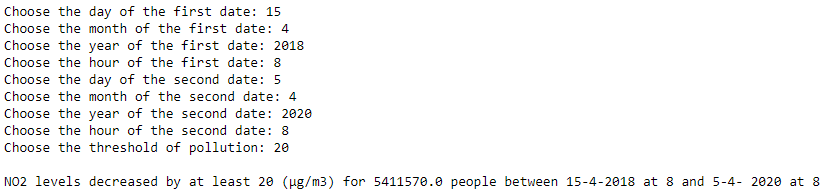

Results in ArcGIS:

Interpolations:
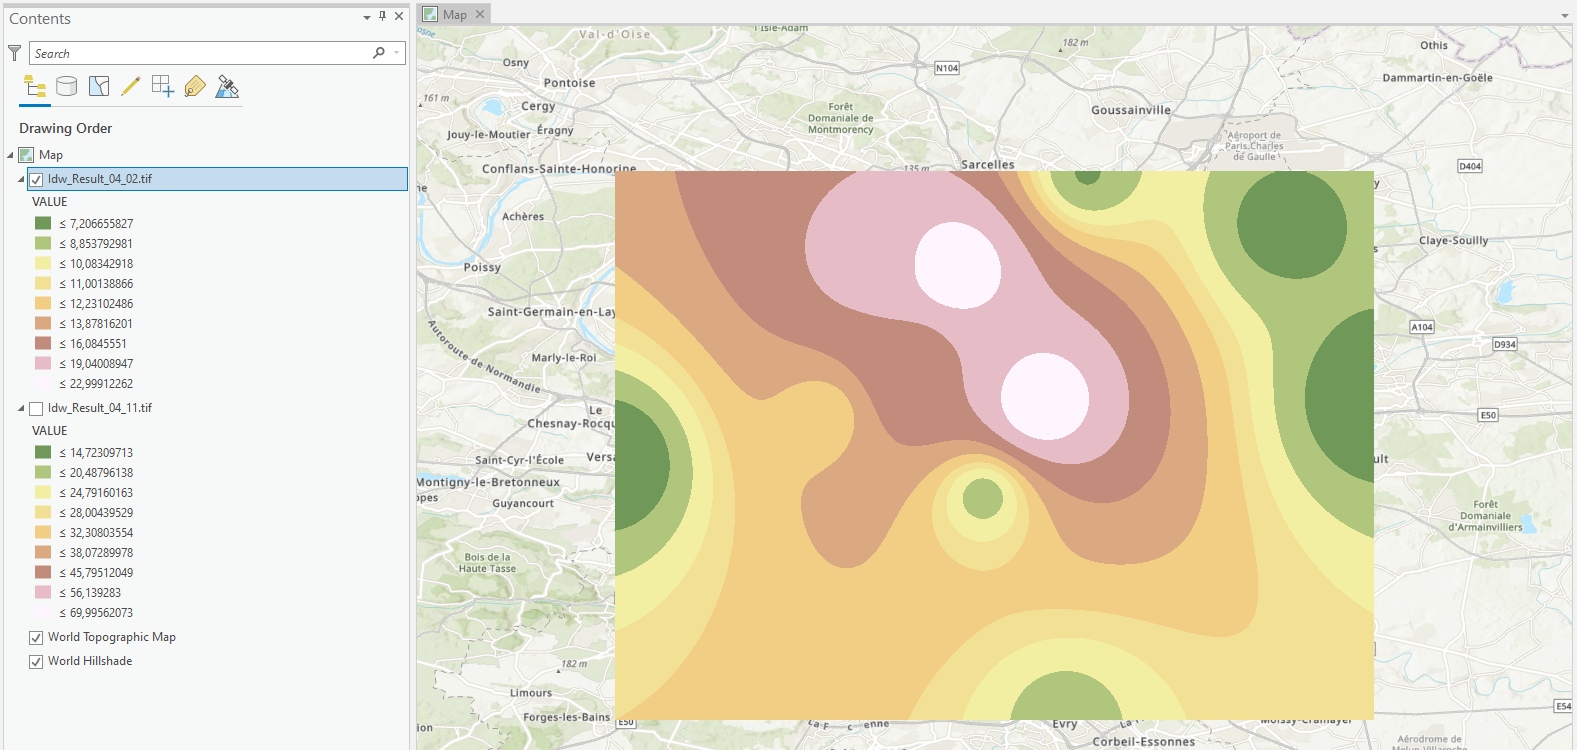

Difference raster:
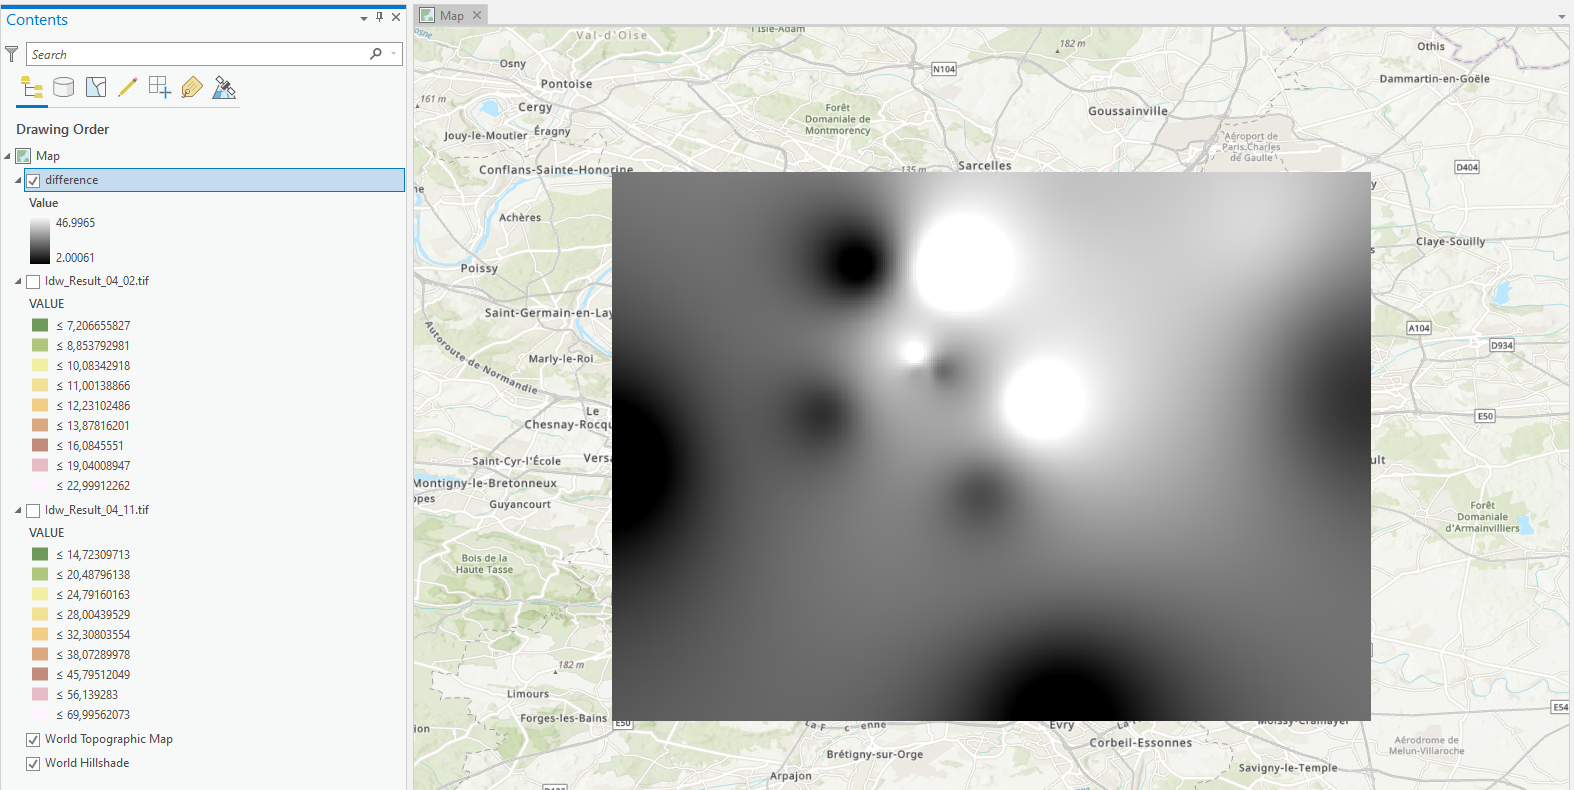

Binary raster:
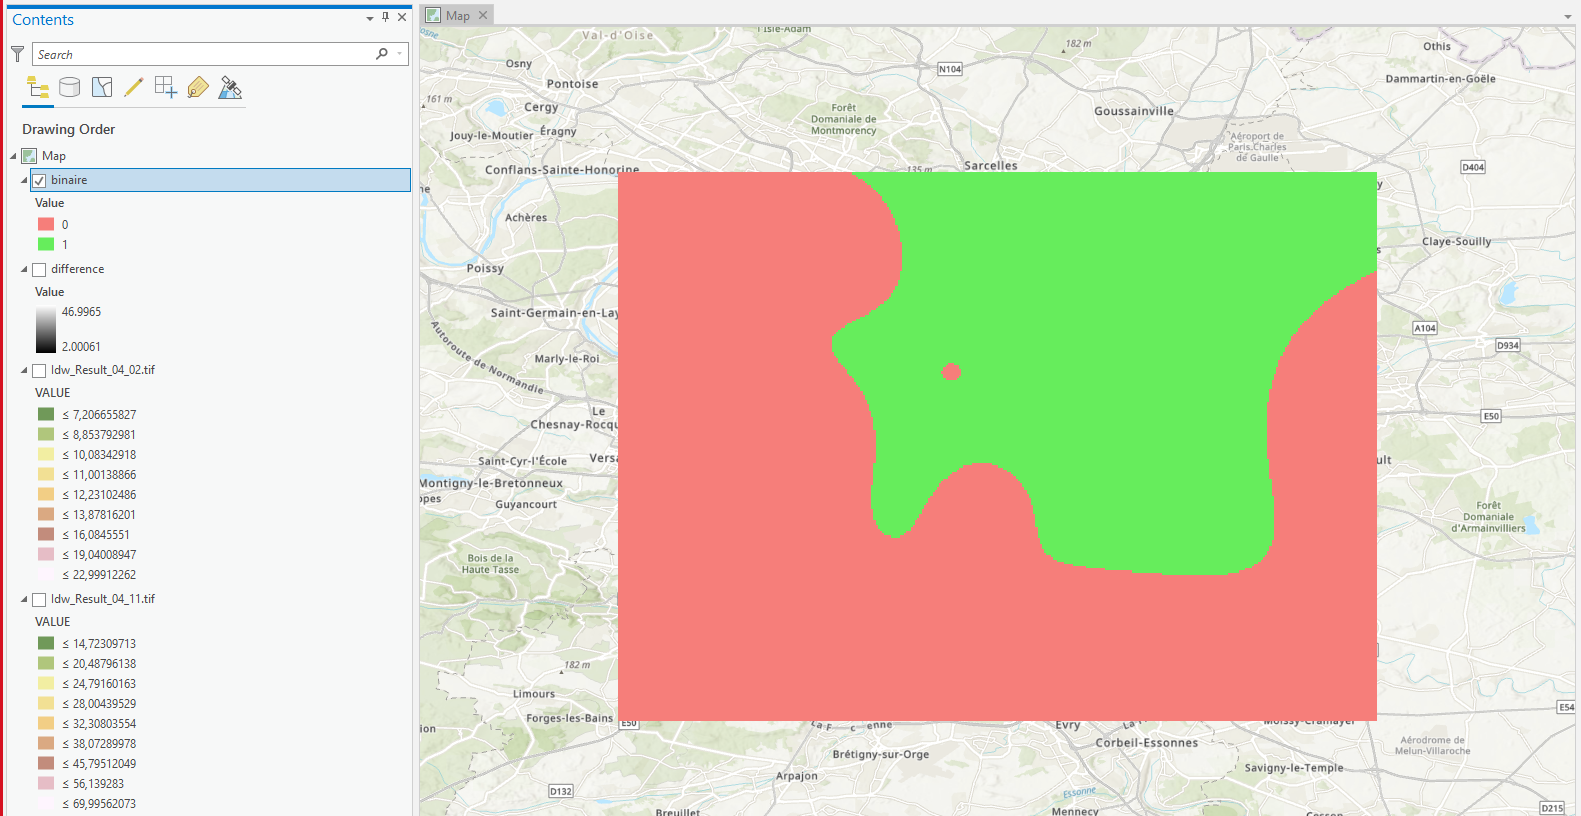

Population density raster:
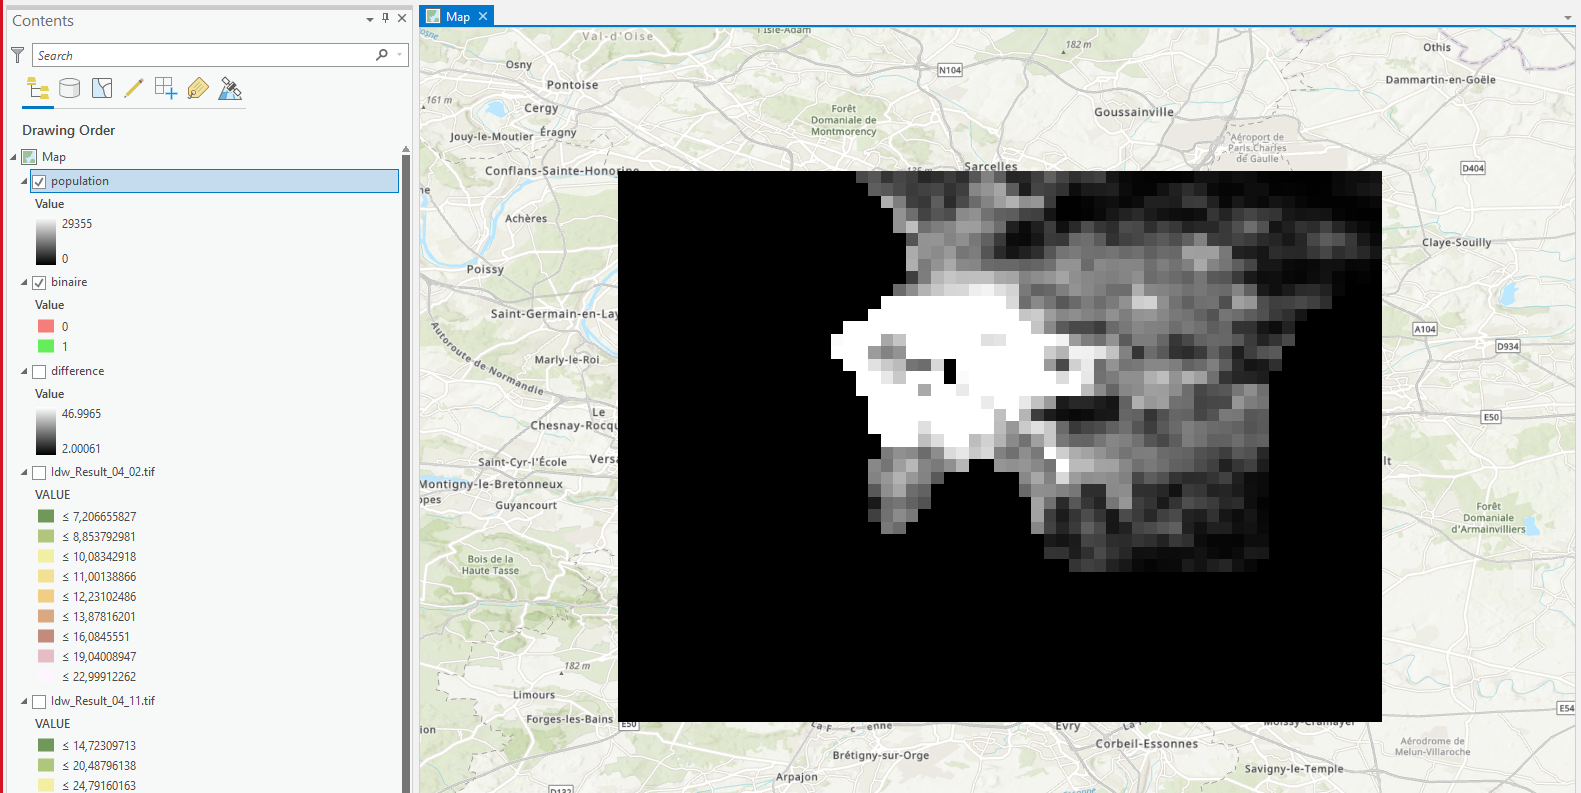

In [ ]:
day1 = int(input("Choose the day of the first date: "))
month1 = int(input("Choose the month of the first date: "))
year1 = int(input("Choose the year of the first date: "))
hour1 = int(input("Choose the hour of the first date: "))

day2 = int(input("Choose the day of the second date: "))
month2 = int(input("Choose the month of the second date: "))
year2 = int(input("Choose the year of the second date: "))
hour2 = int(input("Choose the hour of the second date: "))

threshold = int(input("Choose the threshold of pollution: "))

amount = Pop_pollu(day1,month1,year1,day2,month2,year2,hour1,hour2,threshold)

print("\nNO2 levels decreased by at least", threshold, "(µg/m3) for", round(amount), "people between",
      str(day1) + "-" + str(month1) + "-" + str(year1), "at",
      hour1, "and", str(day2) + "-" + str(month2) + "-" + str(year2), "at", hour2)
      